**Содержание:**

- Задание 

- Импорт библиотек и подключение google диска

- Прогнозирование акций Лукойл

  - Работа с таблицей
  - Загрузка данных
  - Дополнительные функции визуализации результатов

- Задание 1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

  - lr=1e-4
  - Уменьшаем шаг обучения lr=1e-5
  - График lr=1e-5
  - Прогноз данных, отображение на графике
  - График корреляции
  - График корреляции со смещением шага

- Задание 2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.
  - lr=1e-4
  - Уменьшаем шаг обучения lr=1e-5
  - График lr=1e-5
  - Прогноз данных, отображение на графике
  - График корреляции
  - График корреляции со смещением шага

- Задание 3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

- Задача 4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой
  - Обучение сети (шаг обучения lr=1e-5)
  - График lr=1e-5
  - Прогноз данных, отображение на графике (lr=1e-5)
  - График корреляции (lr=1e-5)
  - График корреляции со смещением шага (lr=1e-5)
  - Графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания

- Выводы

# Задание 

**Задание Lite**

Работа осуществляется с базой акции лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

# Импорт библиотек и подключение google диска

In [ ]:
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector, Input, concatenate
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Прогнозирование акций Лукойл

## Работа с таблицей

In [ ]:
# Считываем данные и присваеваем переменной с помощью pandas
# Загрузим данные за 16-17 и 18-19 годы
data16_17 = pd.read_csv('/content/drive/MyDrive/Временные ряды/База акции Лукойла/16_17.csv', sep=';')
data18_19 = pd.read_csv('/content/drive/MyDrive/Временные ряды/База акции Лукойла/18_19.csv', sep=';')

In [ ]:
# Убираем колонки DATE и TIME
data16_17 = data16_17.iloc[:,2:]
data18_19 = data18_19.iloc[:,2:]

In [ ]:
# Объединяем две базы в одну
#data = data16_17.copy()
data = pd.concat([data16_17, data18_19])

# Переводим в numpy массив
data = np.array(data)

## Загрузка данных

In [ ]:
xLen = 300                               # Анализ по xLen прошедшим точкам
valLen = 40002                           # Кол-во на проверочную выборку

trainLen = data.shape[0] - valLen        # Размер тренировочной выборки (зависит от значения valLen)

# Делим данные на выборки проверочную и тестовую

# Берем только 3 столбец Close(по заданию - Используйте только столбец close )
xTrain = np.reshape(data[:trainLen, 3],(-1,1))
xTest  = np.reshape(data[trainLen + xLen + 2:, 3],(-1,1))

# Нормализируем данные
xScaler = MinMaxScaler()
xScaler.fit(xTrain)

xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print('xTrain:', xTrain.shape)
print('xTest:', xTest.shape)

# Делаем reshape на тестовых данных и нормализуем их

yTrain = np.reshape(data[:trainLen, 3],(-1,1))
yTest  = np.reshape(data[trainLen + xLen + 2:, 3],(-1,1))

print('\nПосле reshape:')
print('yTrain:', yTrain.shape)
print('yTest:', yTest.shape)

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

xTrain: (441870, 1)
xTest: (39700, 1)

После reshape:
yTrain: (441870, 1)
yTest: (39700, 1)


In [ ]:
# Создаем генератор для обучающей выборки
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length= xLen, stride=1, sampling_rate=1, batch_size=20)

In [ ]:
# Аналогично для валидационной выборки
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, stride=1 , batch_size=20, sampling_rate=1)

In [ ]:
# Сразу получим значения и переведем в numpy массив для проверки
DataGen = TimeseriesGenerator(xTest, yTest, length=300, sampling_rate=1, batch_size=len(xTest)) 

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

## Дополнительные функции визуализации результатов

In [ ]:
# Функция для рассчета результата прогнозирования сети
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)                  # Возврат предсказанного результата и реальных данных

In [ ]:
# Функция визуализации графиков предсказания и реальных данных
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start:start+step, 0], label = 'Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

In [ ]:
# Рассчет корреляции двух векторов
def correlate(a,b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb) / (sa*sb)
  return val

In [ ]:
# Функция отрисовки графика корреляции со смещением шага для проверки автокорреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = [] 
    yLen = yValUnscaled.shape[0] 

    # C помощью цикла изменяем шаг
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = []  # Список для эталонного грфика автокорреляции, к которому нужно стремиться

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')   # Для предсказанных значений
    plt.plot(own_corr, label='Эталон')                              # Для эталона

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

# Задание 1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

**Нейронная сеть с Dense слоем**

In [ ]:
modelD = Sequential()
modelD.add(Dense(200, input_shape = (xLen,1), activation='relu'))
modelD.add(Dense(150, activation='relu'))
modelD.add(Flatten())
#modelD.add(Dropout(0.4))
modelD.add(Dense(1, activation='linear'))

modelD.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

modelD.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300, 200)          400       
_________________________________________________________________
dense_1 (Dense)              (None, 300, 150)          30150     
_________________________________________________________________
flatten (Flatten)            (None, 45000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 45000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 45001     
Total params: 75,551
Trainable params: 75,551
Non-trainable params: 0
_________________________________________________________________


## lr=1e-4

In [ ]:
# Обучение
historyD = modelD.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
22079/22079 [==============================] - 86s 4ms/step - loss: 2.3275e-04 - val_loss: 1.1687e-04
Epoch 2/30
22079/22079 [==============================] - 84s 4ms/step - loss: 1.3131e-04 - val_loss: 9.4675e-05
Epoch 3/30
22079/22079 [==============================] - 84s 4ms/step - loss: 1.1322e-04 - val_loss: 1.0201e-04
Epoch 4/30
22079/22079 [==============================] - 82s 4ms/step - loss: 1.0934e-04 - val_loss: 4.1716e-04
Epoch 5/30
22079/22079 [==============================] - 82s 4ms/step - loss: 9.6122e-05 - val_loss: 9.8614e-05
Epoch 6/30
22079/22079 [==============================] - 83s 4ms/step - loss: 8.6949e-05 - val_loss: 2.0788e-04
Epoch 7/30
22079/22079 [==============================] - 83s 4ms/step - loss: 8.3752e-05 - val_loss: 4.0183e-05
Epoch 8/30
22079/22079 [==============================] - 82s 4ms/step - loss: 8.0442e-05 - val_loss: 9.5772e-05
Epoch 9/30
22079/22079 [==============================] - 82s 4ms/step - loss: 8.0584e-05 - val_

## Уменьшаем шаг обучения lr=1e-5

In [ ]:
modelD.compile(loss='mse', optimizer=Adam(learning_rate=1e-5))
historyD = modelD.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.5119e-05 - val_loss: 5.0791e-05
Epoch 2/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.4467e-05 - val_loss: 3.5106e-05
Epoch 3/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.4197e-05 - val_loss: 3.5128e-05
Epoch 4/30
22079/22079 [==============================] - 81s 4ms/step - loss: 4.4608e-05 - val_loss: 3.7473e-05
Epoch 5/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.4327e-05 - val_loss: 3.6511e-05
Epoch 6/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.4131e-05 - val_loss: 4.0231e-05
Epoch 7/30
22079/22079 [==============================] - 81s 4ms/step - loss: 4.4130e-05 - val_loss: 3.7976e-05
Epoch 8/30
22079/22079 [==============================] - 81s 4ms/step - loss: 4.3588e-05 - val_loss: 3.9494e-05
Epoch 9/30
22079/22079 [==============================] - 82s 4ms/step - loss: 4.4070e-05 - val_

## График lr=1e-5

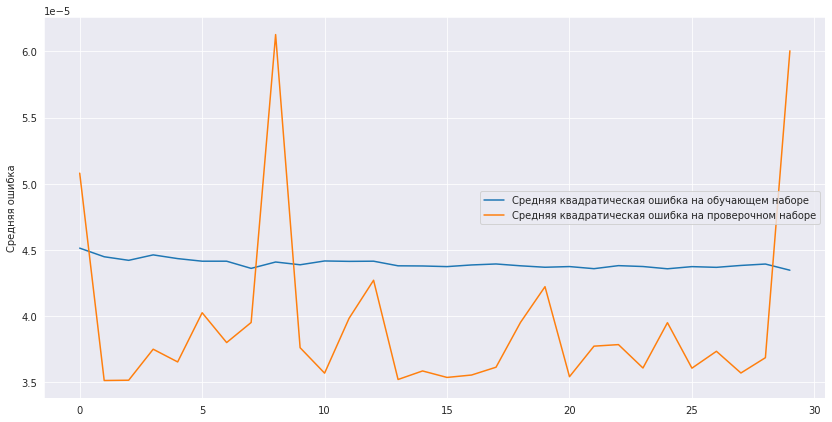

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyD.history['loss'], label='Средняя квадратическая ошибка на обучающем наборе')
plt.plot(historyD.history['val_loss'], label='Средняя квадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Прогноз данных, отображение на графике

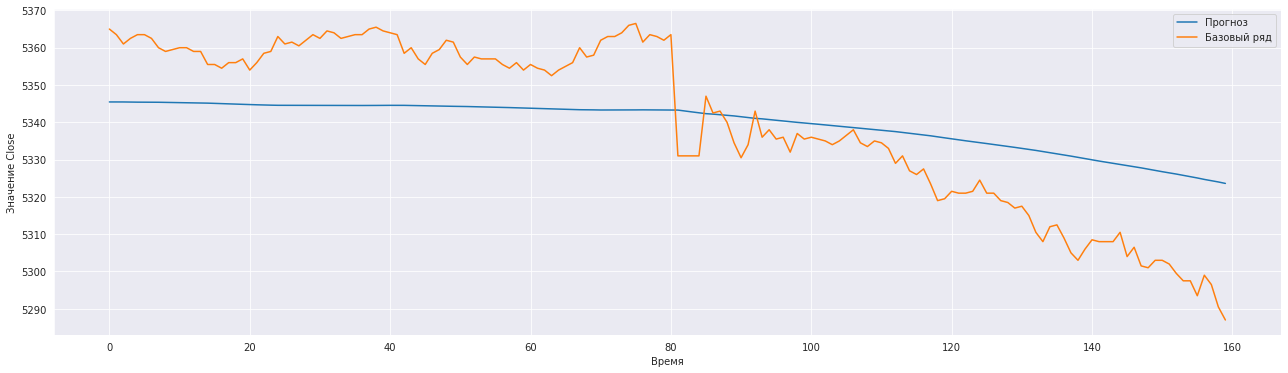

In [ ]:
(predVal_D, yValUnscaled_D) = getPred(modelD, xVal[0], yVal[0], yScaler)   # Прогноз данных
showPredict(0, 160, 0, predVal_D, yValUnscaled_D)

## График корреляции

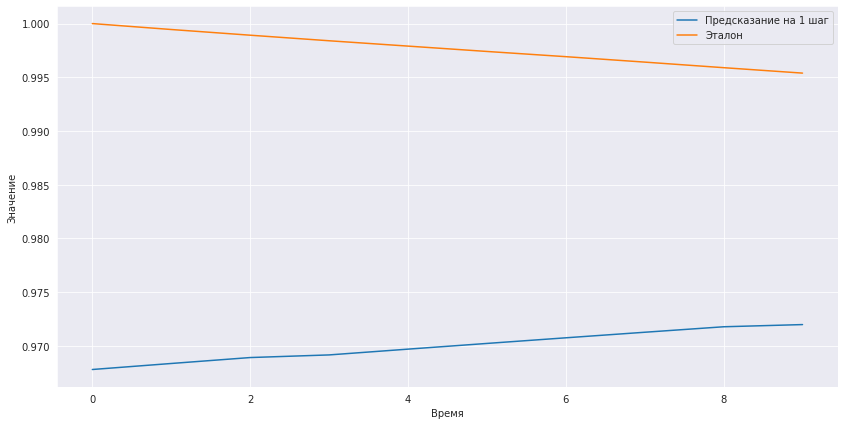

In [ ]:
showCorr([0], 10, predVal_D, yValUnscaled_D)

## График корреляции со смещением шага

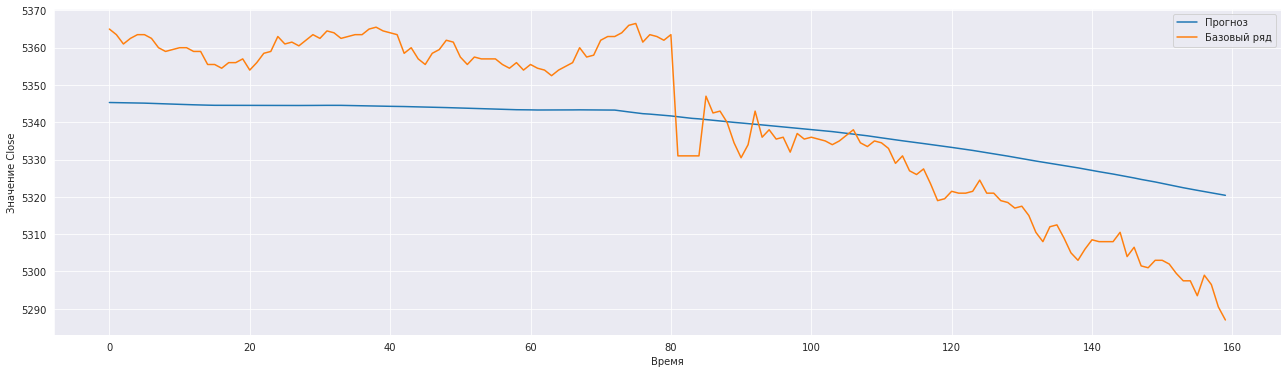

In [ ]:
showPredict(0,160,0, predVal_D[9:], yValUnscaled_D[:-9])

# Задание 2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

In [ ]:
# Сформируем данные для прогноза на 10 шагов
xLen = 300
valLen = 40002
steps = 10          # для прогноза на 10 шагов

trainLen = data.shape[0] - valLen

In [ ]:
# Формируем обучающую выборку

xTrain = np.reshape(data[:trainLen - steps, 3],(-1,1))
xTest  = np.reshape(data[trainLen + xLen + 2: -steps, 3] ,(-1,1))

# Нормализация
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest  = xScaler.transform(xTest)

print('xTrain:', xTrain.shape)
print('xTest:', xTest.shape)


# xTrain: (441870, 1)
# xTest: (39700, 1)

xTrain: (441860, 1)
xTest: (39690, 1)


In [ ]:
# Для уTrain и yTest нужно преобразовать выборки, окно с шагом в 10

yTrain = []
yTest = []
for i in range(trainLen - steps):
  yTrain.append(data[:trainLen, 3][i: i + steps])

for i in range(valLen - xLen - steps -2 ):
  yTest.append(data[trainLen + xLen + 2:, 3][i: i + steps])

yTrain = np.array(yTrain)
yTest = np.array(yTest)

yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest  = yScaler.transform(yTest)


print('После reshape:')
print('yTrain:', yTrain.shape)
print('yTest:', yTest.shape)

После reshape:
yTrain: (441860, 10)
yTest: (39690, 10)


In [ ]:
#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, stride=1, sampling_rate=1, batch_size=20)

In [ ]:
#Создаем генератор для теста
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, stride=1, batch_size=20)

In [ ]:
# Для проверки
DataGen = TimeseriesGenerator(xTest, yTest, length=xLen, sampling_rate=1, batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yval = np.array(yVal)

In [ ]:
xVal.shape

(1, 39390, 300, 1)

**Возьмем точно такую же нейронную сеть с Dense слоем и обучим ее**

In [ ]:
modelD_10 = Sequential()
modelD_10.add(Dense(200, input_shape = (xLen,1), activation='relu'))
modelD_10.add(Dense(150, activation='relu'))
modelD_10.add(Flatten())
#modelD_10.add(Dropout(0.4))
modelD_10.add(Dense(10, activation='linear'))

modelD_10.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))

modelD_10.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300, 200)          400       
_________________________________________________________________
dense_7 (Dense)              (None, 300, 150)          30150     
_________________________________________________________________
flatten_2 (Flatten)          (None, 45000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                450010    
Total params: 480,560
Trainable params: 480,560
Non-trainable params: 0
_________________________________________________________________


## lr=1e-4

In [ ]:
# Обучение
historyD_10 = modelD_10.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
22078/22078 [==============================] - 96s 4ms/step - loss: 1.5105e-04 - val_loss: 3.6438e-04
Epoch 2/30
22078/22078 [==============================] - 94s 4ms/step - loss: 5.3305e-05 - val_loss: 3.7961e-05
Epoch 3/30
22078/22078 [==============================] - 93s 4ms/step - loss: 3.5536e-05 - val_loss: 2.5020e-05
Epoch 4/30
22078/22078 [==============================] - 93s 4ms/step - loss: 2.8102e-05 - val_loss: 2.3732e-04
Epoch 5/30
22078/22078 [==============================] - 94s 4ms/step - loss: 2.4538e-05 - val_loss: 1.7221e-05
Epoch 6/30
22078/22078 [==============================] - 94s 4ms/step - loss: 2.1816e-05 - val_loss: 1.7316e-05
Epoch 7/30
22078/22078 [==============================] - 95s 4ms/step - loss: 1.9369e-05 - val_loss: 2.1458e-04
Epoch 8/30
22078/22078 [==============================] - 93s 4ms/step - loss: 1.8524e-05 - val_loss: 2.2415e-05
Epoch 9/30
22078/22078 [==============================] - 90s 4ms/step - loss: 1.8438e-05 - val_

## Уменьшаем шаг обучения lr=1e-5

In [ ]:
modelD_10.compile(loss='mse', optimizer=Adam(learning_rate=1e-5))
historyD_10 = modelD_10.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
22078/22078 [==============================] - 96s 4ms/step - loss: 4.7541e-06 - val_loss: 9.3648e-06
Epoch 2/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.7005e-06 - val_loss: 9.0622e-06
Epoch 3/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.6689e-06 - val_loss: 7.8994e-06
Epoch 4/30
22078/22078 [==============================] - 96s 4ms/step - loss: 4.6609e-06 - val_loss: 7.9564e-06
Epoch 5/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.6755e-06 - val_loss: 9.4786e-06
Epoch 6/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.6704e-06 - val_loss: 1.1968e-05
Epoch 7/30
22078/22078 [==============================] - 96s 4ms/step - loss: 4.6644e-06 - val_loss: 7.7969e-06
Epoch 8/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.5928e-06 - val_loss: 8.7637e-06
Epoch 9/30
22078/22078 [==============================] - 95s 4ms/step - loss: 4.5670e-06 - val_

In [ ]:
#Сохраним веса
modelD_10.save_weights('loss: 4.5000e-05 - val_loss: 3.8214e-05.h5')

## График lr=1e-5

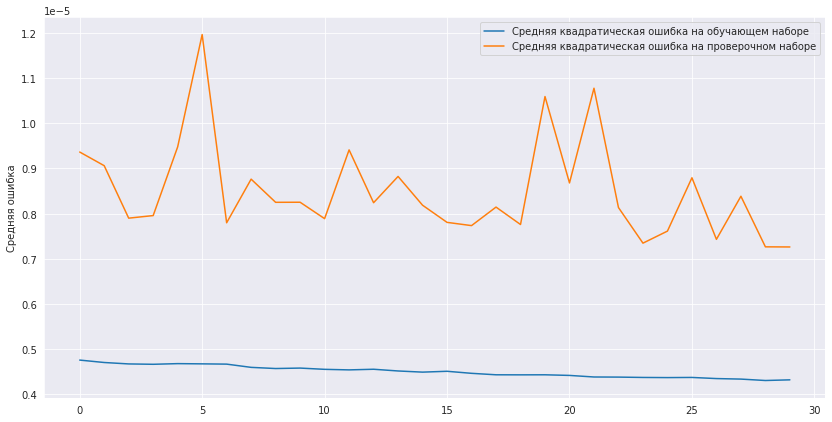

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(historyD_10.history['loss'], label='Средняя квадратическая ошибка на обучающем наборе')
plt.plot(historyD_10.history['val_loss'], label='Средняя квадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Прогноз данных, отображение на графике

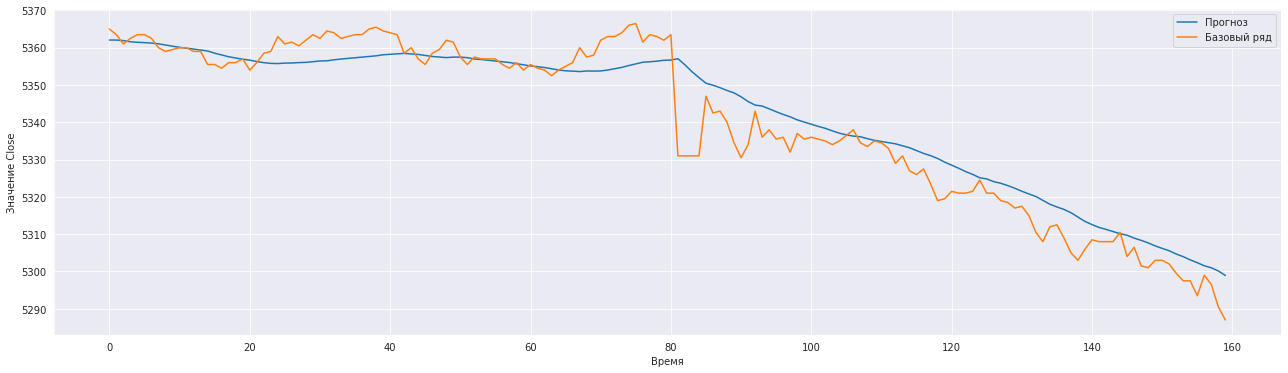

In [ ]:
(predVal_D_10, yValUnscaled_D_10) = getPred(modelD_10, xVal[0], yVal[0], yScaler)  # Прогноз данных
showPredict(0, 160, 0, predVal_D_10, yValUnscaled_D_10)

## График корреляции

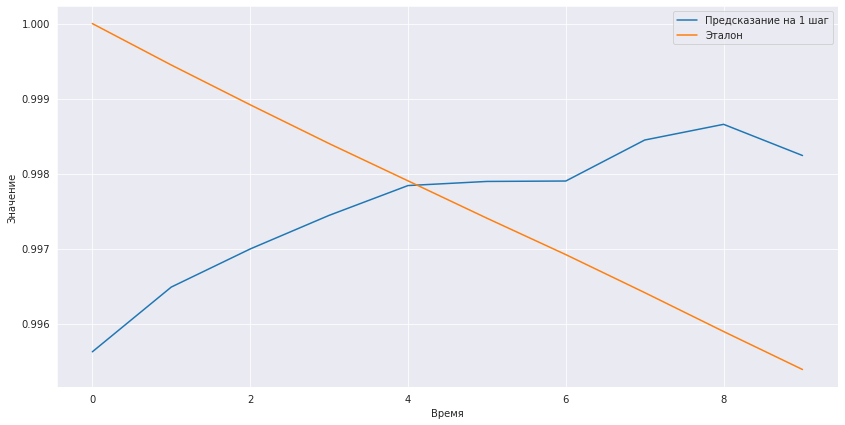

In [ ]:
showCorr([0], 10, predVal_D_10, yValUnscaled_D_10)

## График корреляции со смещением шага

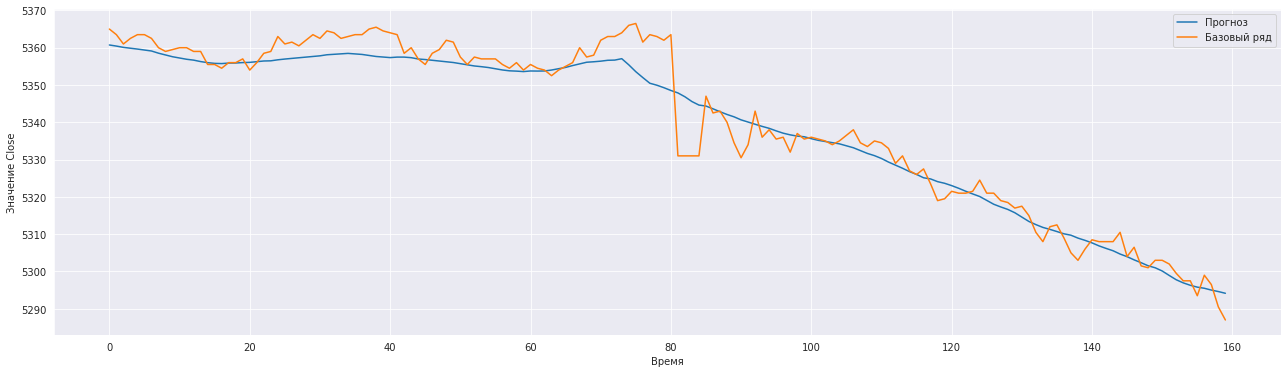

In [ ]:
showPredict(0,160,0, predVal_D_10[8:], yValUnscaled_D_10[:-8])

# Задание 3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

In [ ]:
# Для этого изменим функцию графиков, добавив в plot переменную channel
def showPredictChannel(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(22,6))
  plt.plot(predVal[start : start + step, channel], label = 'Прогноз')
  plt.plot(yValUnscaled[start : start + step, channel], label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

Шаг предсказания:  1


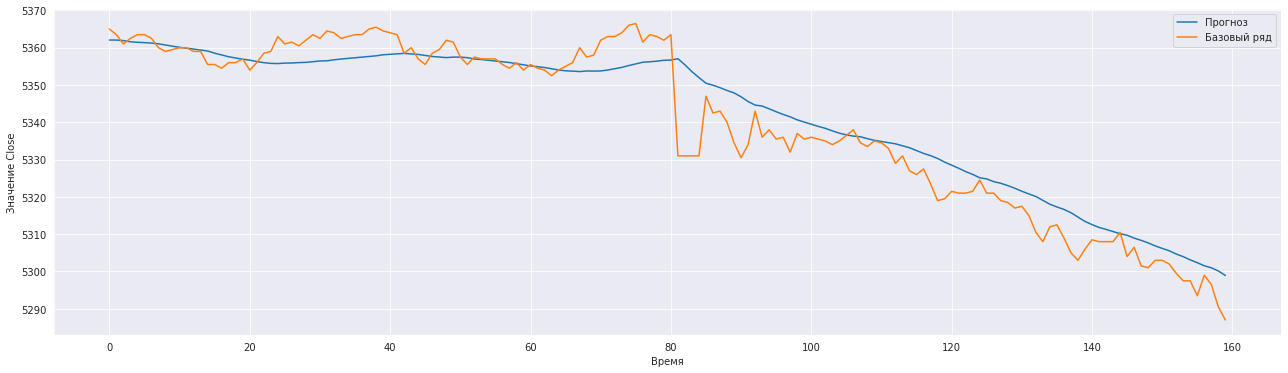

Шаг предсказания:  2


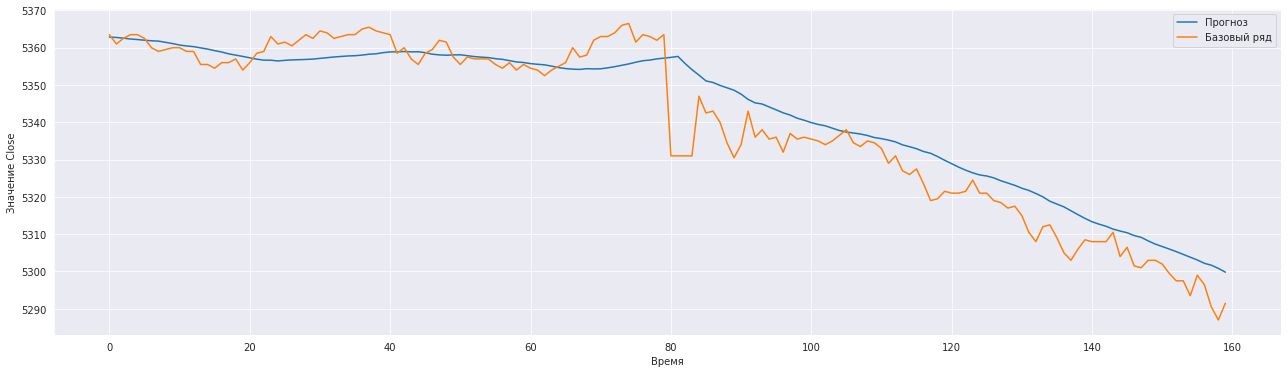

Шаг предсказания:  3


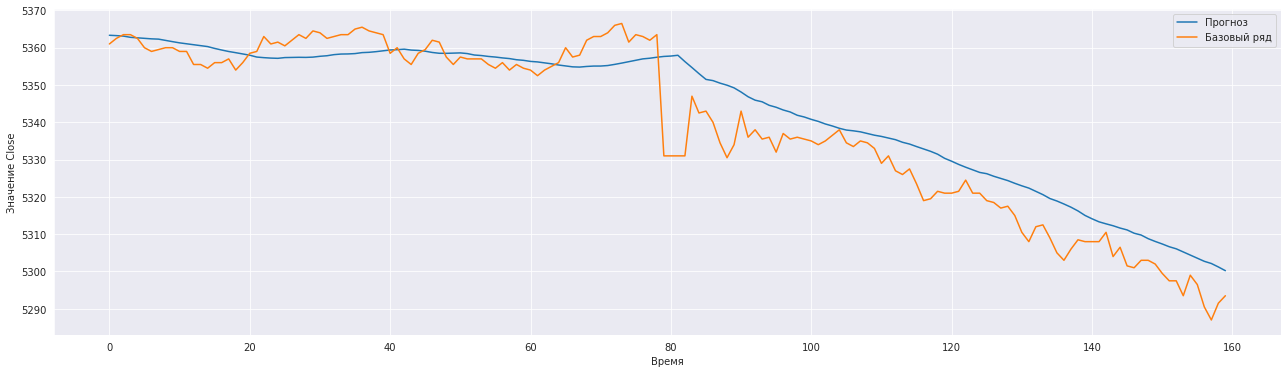

Шаг предсказания:  4


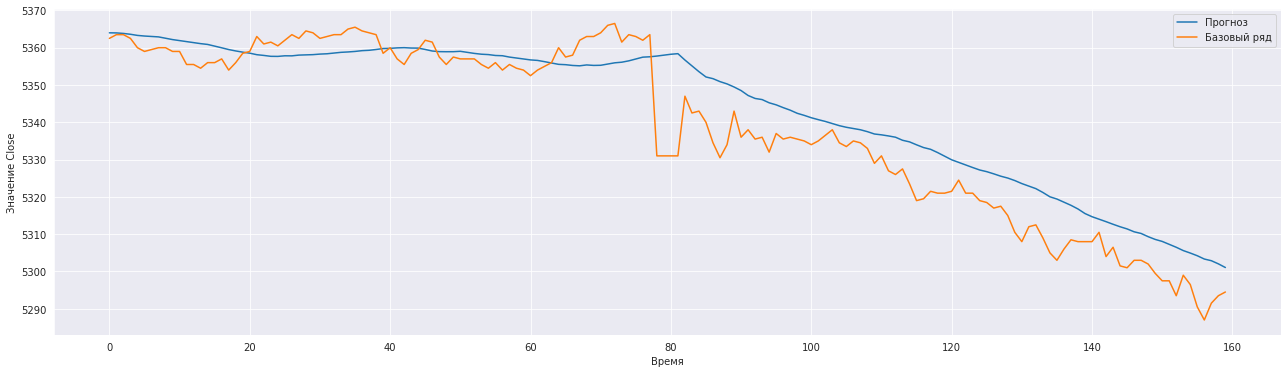

Шаг предсказания:  5


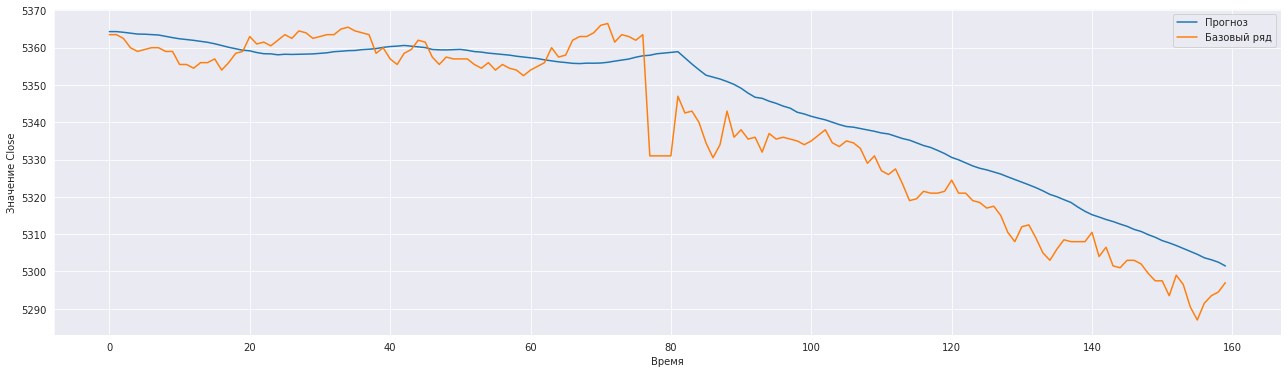

Шаг предсказания:  6


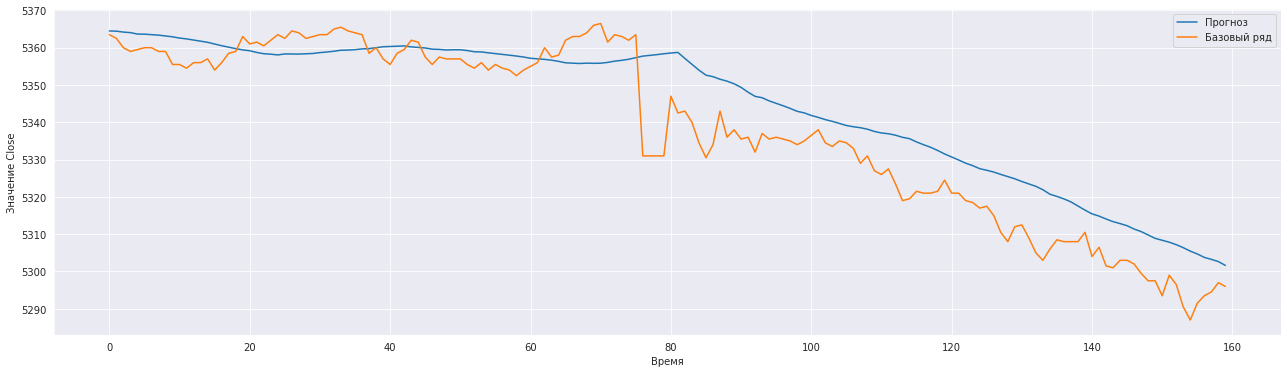

Шаг предсказания:  7


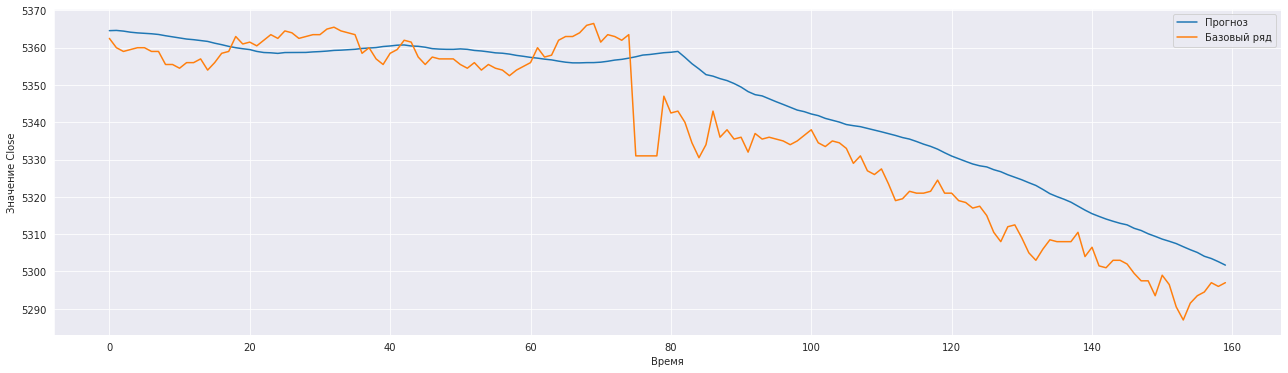

Шаг предсказания:  8


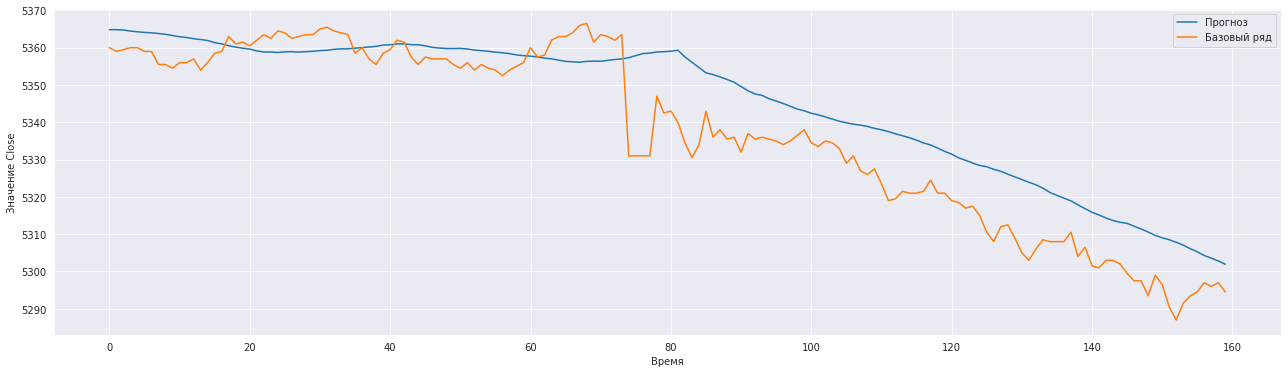

Шаг предсказания:  9


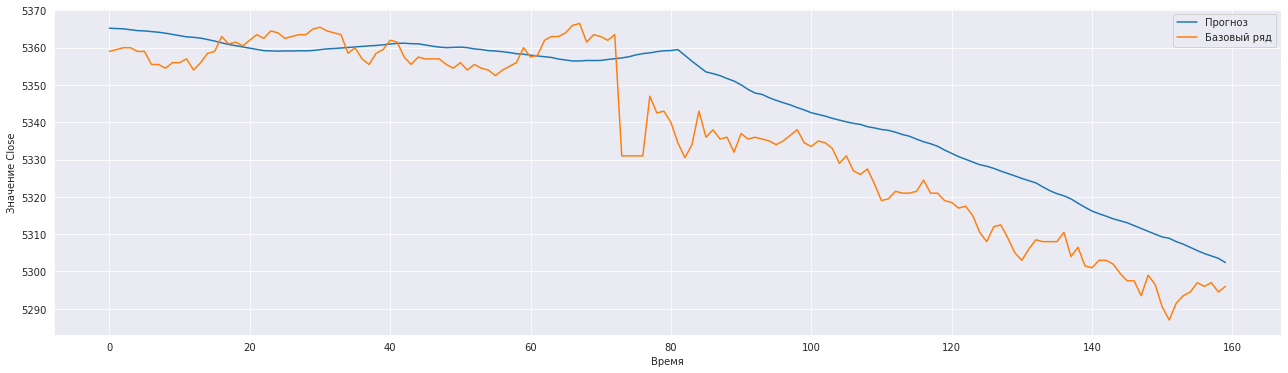

Шаг предсказания:  10


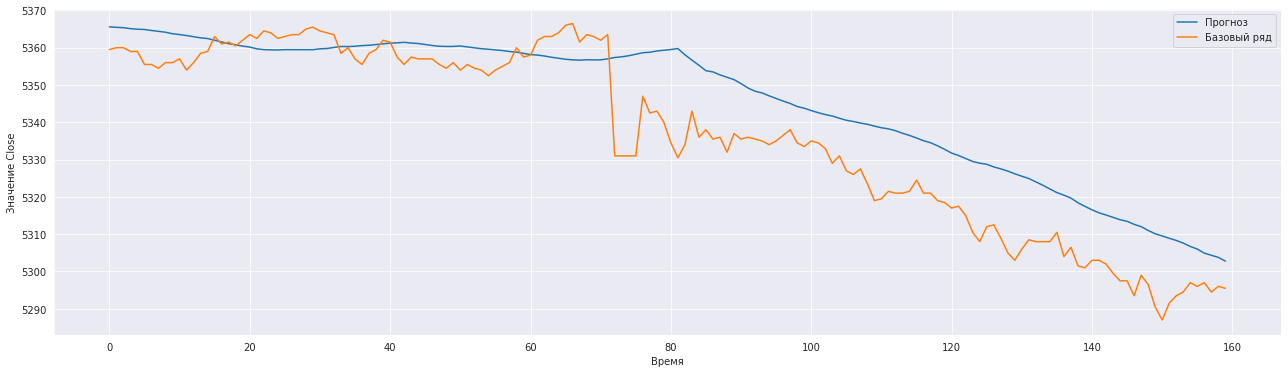

In [ ]:
# Вывод 10 графиков
for i in range(10):
  print('Шаг предсказания: ', i+1)
  showPredictChannel(0,160, i, predVal_D_10, yValUnscaled_D_10)

# Задача 4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

**LSTM сеть**

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(5, input_shape=(xLen,1)))
model_LSTM.add(Dense(50, activation='relu'))
model_LSTM.add(Dense(10, activation='linear'))

model_LSTM.compile(loss='mse', optimizer=Adam(learning_rate=1e-5))

model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense_9 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                510       
Total params: 950
Trainable params: 950
Non-trainable params: 0
_________________________________________________________________


## Обучение сети (шаг обучения lr=1e-5)

In [ ]:
history_LSTM_10 = model_LSTM.fit(trainDataGen, epochs=20, verbose=1, validation_data=testDataGen)

Epoch 1/20
22078/22078 [==============================] - 254s 11ms/step - loss: 0.0595 - val_loss: 0.0052
Epoch 2/20
22078/22078 [==============================] - 252s 11ms/step - loss: 4.4565e-04 - val_loss: 6.0480e-05
Epoch 3/20
22078/22078 [==============================] - 254s 12ms/step - loss: 4.6187e-05 - val_loss: 4.2396e-05
Epoch 4/20
22078/22078 [==============================] - 257s 12ms/step - loss: 1.4863e-05 - val_loss: 1.6759e-05
Epoch 5/20
22078/22078 [==============================] - 258s 12ms/step - loss: 8.2167e-06 - val_loss: 1.0319e-05
Epoch 6/20
22078/22078 [==============================] - 254s 11ms/step - loss: 5.6518e-06 - val_loss: 1.6427e-05
Epoch 7/20
22078/22078 [==============================] - 254s 12ms/step - loss: 4.5056e-06 - val_loss: 6.2429e-06
Epoch 8/20
22078/22078 [==============================] - 254s 12ms/step - loss: 3.9404e-06 - val_loss: 6.5906e-06
Epoch 9/20
22078/22078 [==============================] - 255s 12ms/step - loss: 3.5729e

#### График lr=1e-5

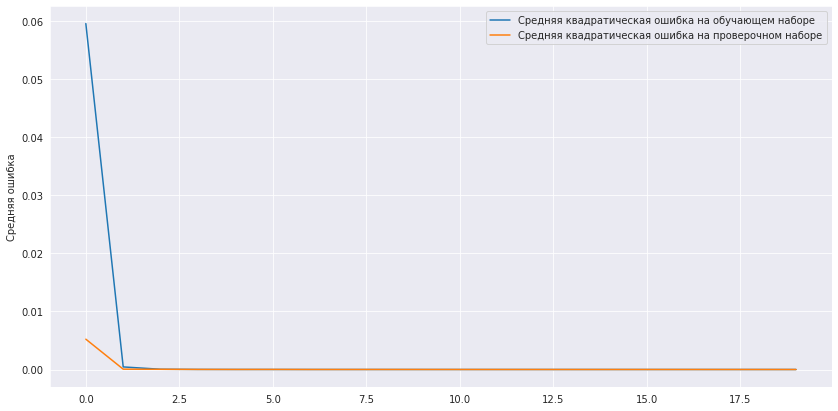

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_LSTM_10.history['loss'], label='Средняя квадратическая ошибка на обучающем наборе')
plt.plot(history_LSTM_10.history['val_loss'], label='Средняя квадратическая ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Прогноз данных, отображение на графике (lr=1e-5)

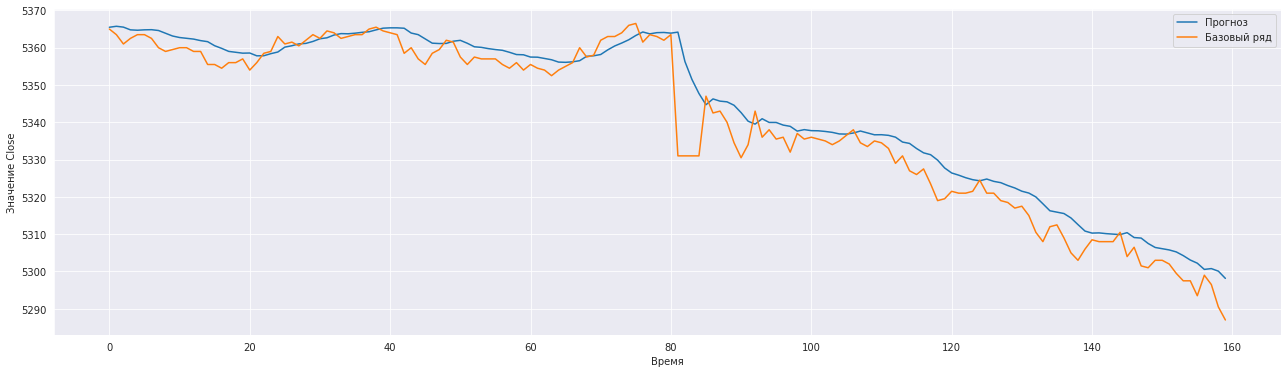

In [ ]:
(predVal_LSTM_10, yValUnscaled_LSTM_10) = getPred(model_LSTM, xVal[0], yVal[0], yScaler)   # Прогноз данных
showPredict(0,160,0, predVal_LSTM_10, yValUnscaled_LSTM_10)


## График корреляции (lr=1e-5)

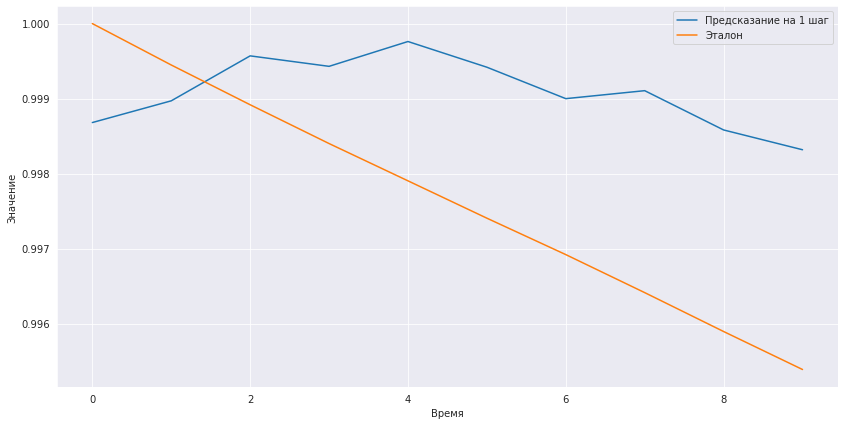

In [ ]:
showCorr([0], 10, predVal_LSTM_10, yValUnscaled_LSTM_10)

## График корреляции со смещением шага (lr=1e-5)

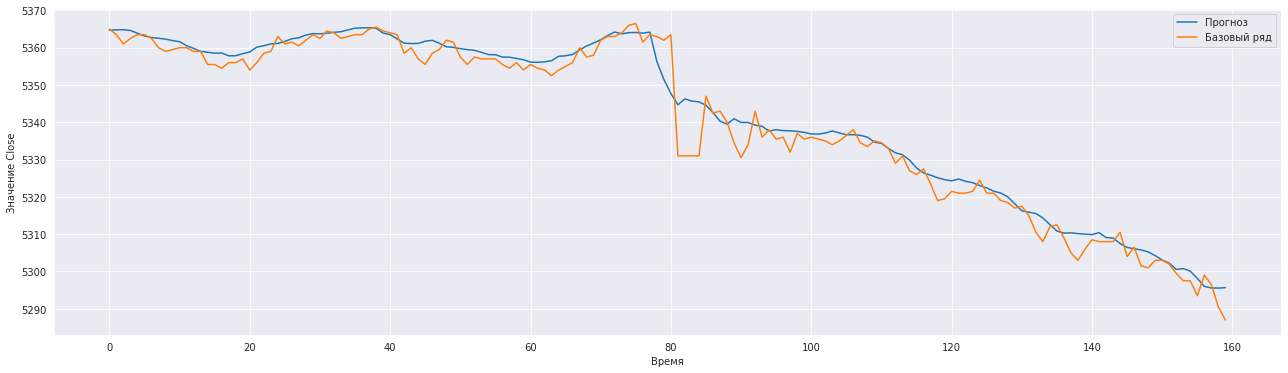

In [ ]:
showPredict(0,160,0, predVal_LSTM_10[4:], yValUnscaled_LSTM_10[:-4])

## Графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания

Шаг предсказания:  1


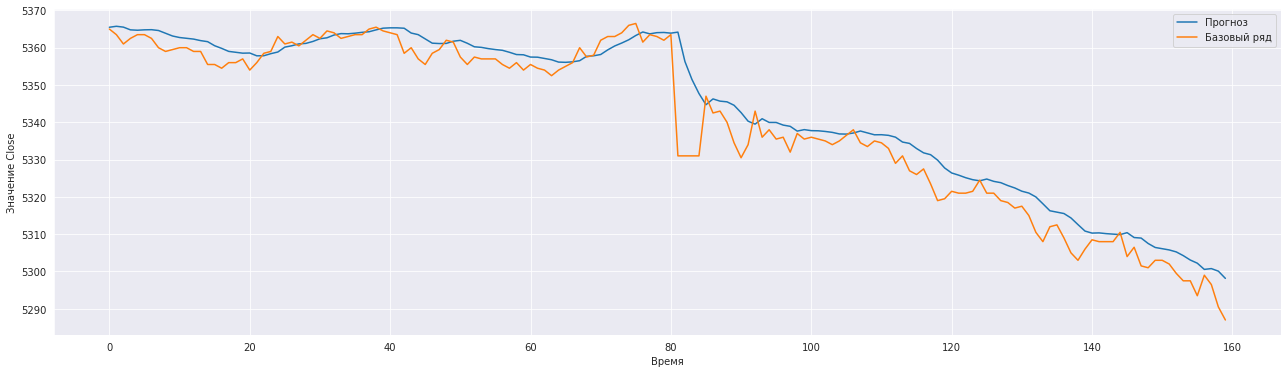

Шаг предсказания:  2


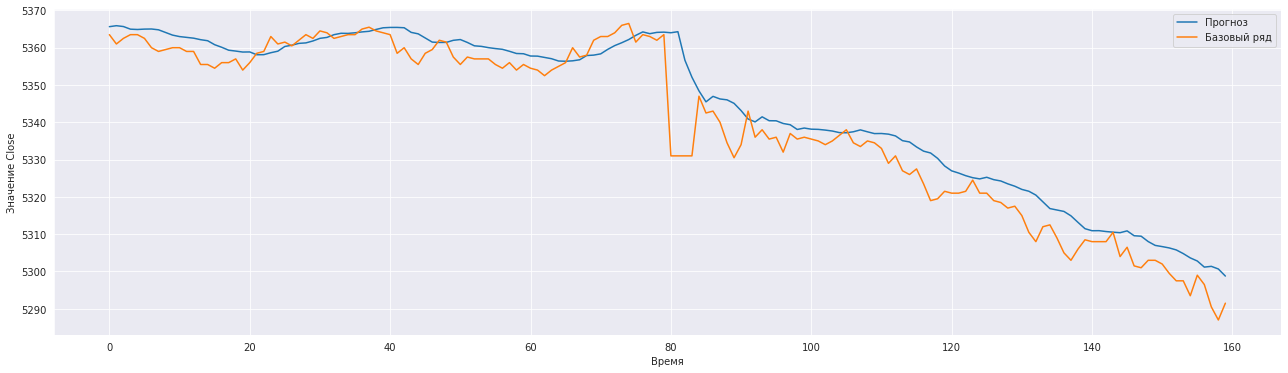

Шаг предсказания:  3


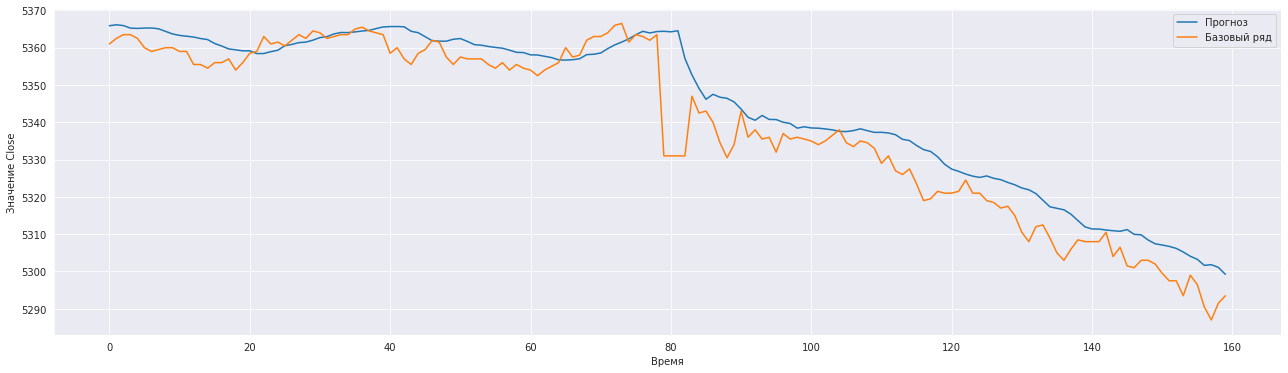

Шаг предсказания:  4


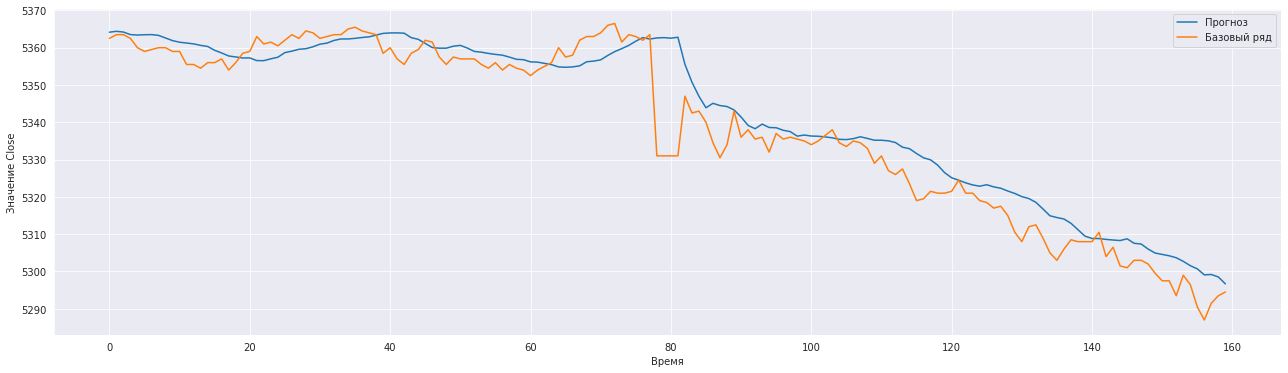

Шаг предсказания:  5


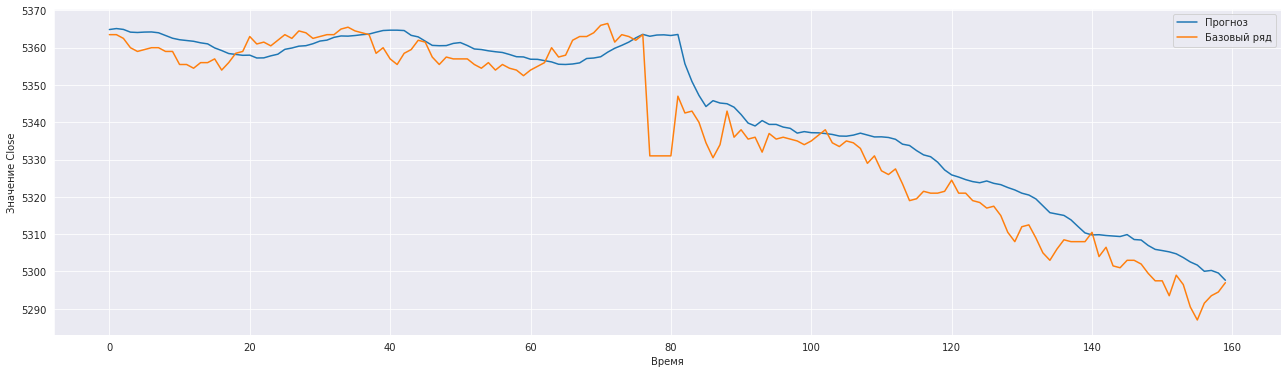

Шаг предсказания:  6


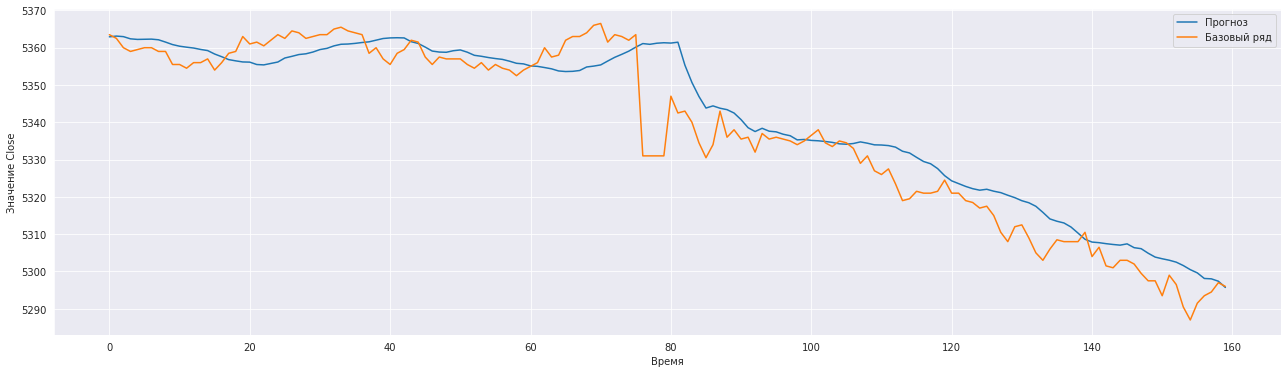

Шаг предсказания:  7


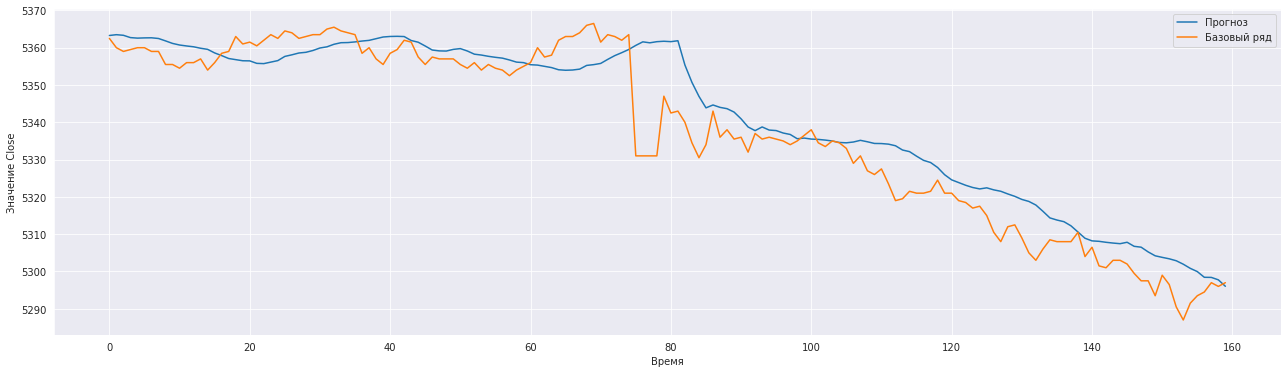

Шаг предсказания:  8


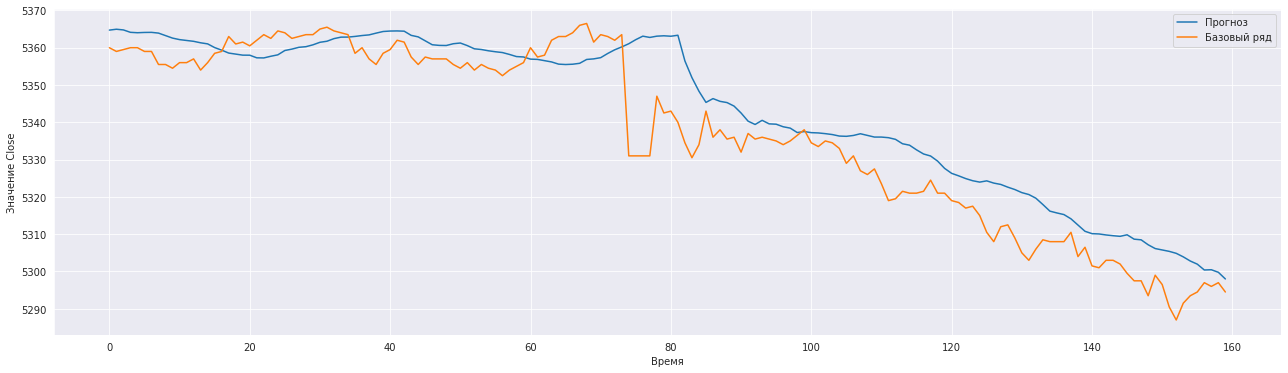

Шаг предсказания:  9


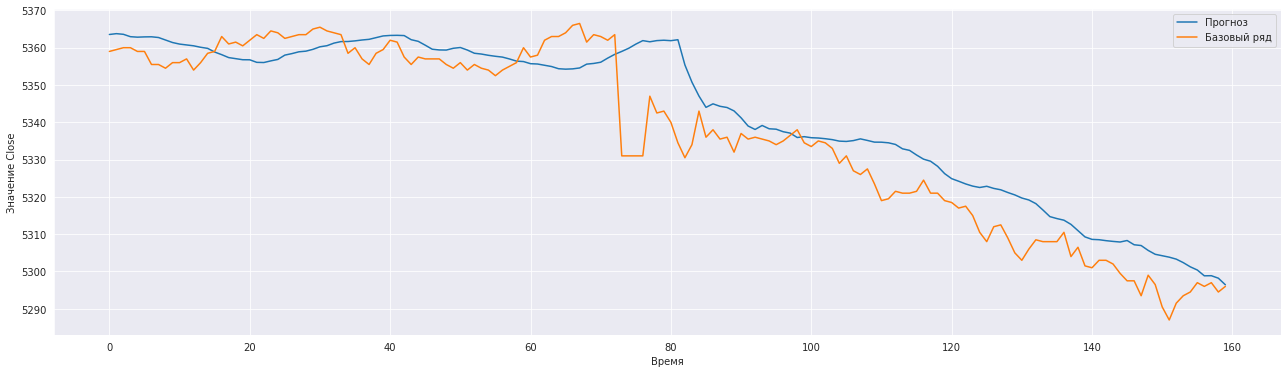

Шаг предсказания:  10


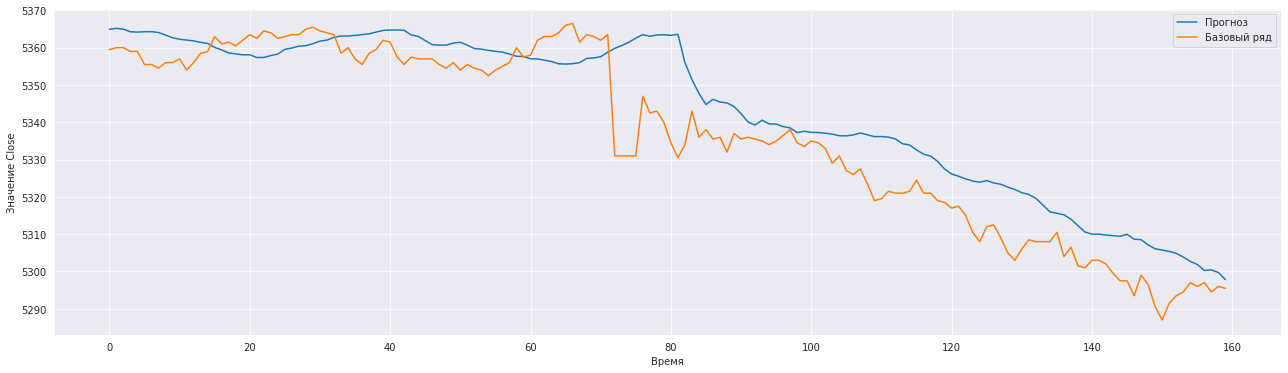

In [ ]:
# Вывод 10 графиков
for i in range(10):
  print('Шаг предсказания: ', i+1)
  showPredictChannel(0,160, i, predVal_LSTM_10, yValUnscaled_LSTM_10)

# Выводы


1. Для того чтобы предсказывать на 10 шагов вперед требуется на выходном слое использовать 10 нейронов.

2. Так же требуется создать нужную обучающую выборку

3. Если обучать сеть только по одному каналу (Close) результат будет хуже чем на полных данных.

4. При предсказании на 1 шаг ошибка на проверочной выборке модели была val_loss: 6.0045e-05, а на той же самой архитектуре сети, но уже предсказание на 10 шагов вперед ошибка уже составила val_loss: 7.2609e-06 

5. Нейронная сеть с LSTM дала результат на последжней эпохе val_loss: 4.3014e-06. При этом было небольшое число эпох, а так же не было дообучение модели с уменьшением шага lr.

6. Прогнозирование использованием данных нейронныхъ сетей и подтверждает, что качество прогнозирования ухудшилось из-за того, что требуется решить более сложную задачу. 

7. В целом, текущие нейронные сети не могут возвращать очень хорошие прогнозы временных рядов. Это может быть связано с ограниченным набором данных, небольшим количеством эпох обучения и несоответствующей архитектурой, гиперпараметрами и автокорреляции.

8. Не смотря на это нейронные сети могут хорошо справляться с вопросами предсказания временного ряда и помогать в повседнемном решении поставленых задач.